In [5]:
import sys

sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_sparse_spd_matrix
from corner import corner

from active_learning_ratio_estimation.dataset import RatioDataset
from active_learning_ratio_estimation.util import ideal_classifier_probs, negative_log_likelihood_ratio
from active_learning_ratio_estimation.model import RegularRatioModel, BayesianRatioModel

%matplotlib inline

np.random.seed(0)
tf.random.set_seed(0)

In [6]:
def multi_dim_toy_model(alpha, beta):
    
    z_distribution = tfd.Blockwise([
            tfd.Normal(loc=alpha, scale=1),  # z1
            tfd.Normal(loc=beta, scale=3),  # z2
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
                components_distribution=tfd.Normal(
                    loc=[-2, 2],
                    scale=[1, 0.5]
                )
            ),  # z3
            tfd.Exponential(3),  # z4
            tfd.Exponential(0.5),  # z5
        ])
    
    # compose linear transform
    R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7).astype(np.float32)
    transform = tf.linalg.LinearOperatorFullMatrix(R)
    bijector = tfp.bijectors.AffineLinearOperator(scale=transform)
    
    return tfd.TransformedDistribution(distribution=z_distribution, bijector=bijector)

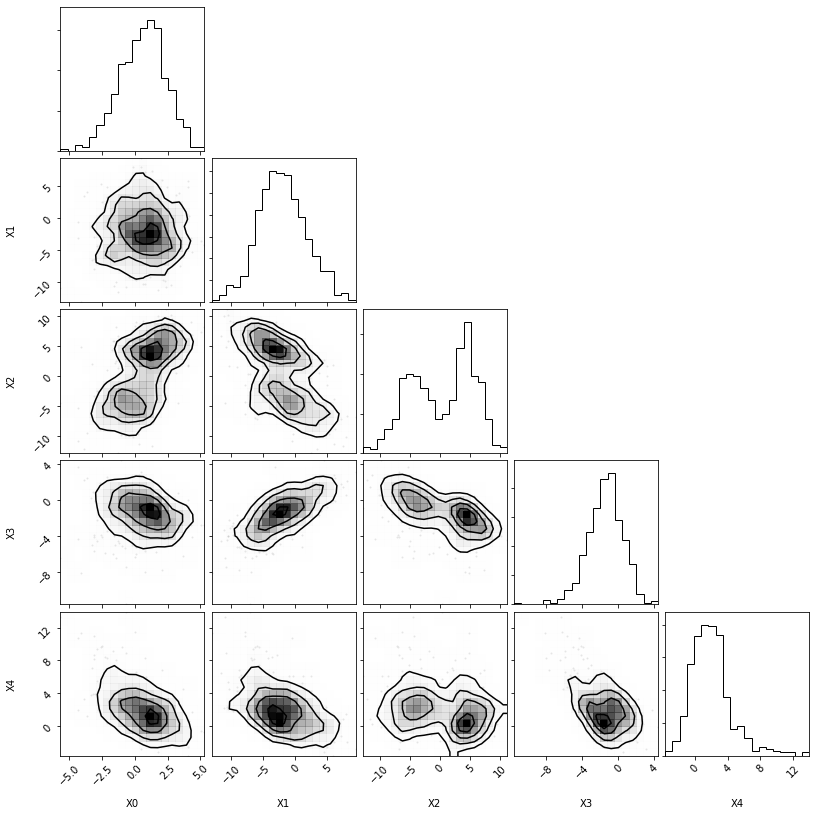

In [7]:
# Plot histograms / correlations of true distributions
true_alpha = 1
true_beta = -1
true_dist = multi_dim_toy_model(alpha=1, beta=-1)
X_true = true_dist.sample(500)
fig = corner(X_true, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

In [8]:
# create dataset